In [1]:
using Plots
using LinearAlgebra
using ForwardDiff
using ControlSystems
using ControlSystemsBase: nonlinearity
using OrdinaryDiffEq
using KernelFunctions
using KernelFunctions:SqEuclidean
using Base.Iterators
using RandomFourierFeatures
using Random, Distributions
using Profile
using FileIO, JLD2
#plotlyjs()

In [44]:
function genSignal_output_shift(sys,n,m,s,time,l,x0,fre=30,amp=1)
    outputx=Vector{Float64}[]
    outputy=Vector{Float64}[]
    t=range(0,time,length=2)
    for ome in range(0,fre,n)
        for a in range(0,amp,m)
            for b in range(0,2*pi,s)
                signal=[sin(ome*x+b)*a for x in range(0,time,length=l)]
                u(x,t) = [sin(ome*t+b)*a]
                y, _, x, uout = lsim(sys,u,t,x0=x0);
                push!(outputy,y[1,:])
                push!(outputx,signal)
            end;
        end;
    end;
    return range(0,time,length=l),outputx,outputy
end;


function genSignal_output_sine(sys,n,m,time,l,x0,amp=0.5)
    outputx=Vector{Float64}[]
    outputy=Vector{Float64}[]
    t=range(0,time,length=l)
    for ome in range(0,21,n)
        for a in range(0,amp,m)
            signal=[sin(ome*x)*a for x in range(0,time,length=l)]
            u(x,t) = [sin(ome*t)*a]
            y, _, x, uout = lsim(sys,u,t,x0=x0);
            push!(outputy,y[1,:])
            push!(outputx,signal)
        end;
    end;
    return range(0,time,length=l),outputx,outputy
end;


function genRandSignal_output(sys,n,m,time,l,x0)
    outputx=[]
    outputy=[]
    t=range(0,time,length=l)
    for ome in range(-3,3,n)
        for a in range(0,0.01,m)
            noise=rand(Uniform(0, 1), 2)
            signal=[sin(exp(ome)*x*noise[1])/(1+10*exp(-a*x*noise[2])) for x in range(0,time,length=l)]
            u(x,t) = [sin(exp(ome)*t*noise[1])/(1+10*exp(-a*t*noise[2]))] 
            y, _, x, uout = lsim(sys,u,t,x0=x0);
            push!(outputy,y[1,:])
            push!(outputx,signal)
        end;
    end;
    return t,outputx,outputy
end;

function genRandSignal_output_sine(sys,n,m,time,l,x0,amp=0.5)
    outputx=[]
    outputy=[]
    t=range(0,time,length=l)
    for ome in range(-3,3,n)
        for a in range(0,amp,m)
            noise=rand(Uniform(0, 1), 2)
            signal=[sin(exp(ome)*x*noise[1])*a for x in range(0,time,length=l)]
            u(x,t) = [sin(exp(ome)*t*noise[1])*a] 
            y, _, x, uout = lsim(sys,u,t,x0=x0);
            push!(outputy,y[1,:])
            push!(outputx,signal)
        end;
    end;
    return t,outputx,outputy
end;



function genSignal_output_step(sys,m,time,l,x0,amp=100)
    outputx=[]
    outputy=[]
    t=range(0,time,length=l)
    for a in range(0,amp,m)
        signal=[exp(100*x)/(exp(100*x)+1)*a for x in range(0,time,length=l)]
        u(x,t) = [exp(100*t)/(exp(100*t)+1)*a] 
        y, _, x, uout = lsim(sys,u,t,x0=x0);
        push!(outputy,y[1,:])
        push!(outputx,signal)
    end;
    return t,outputx,outputy
end;



In [3]:
nl   = nonlinearity(x->clamp(x, -5, 5))
P = nl*tf(zpk([], [-5], 1))
x0=zeros(1);

In [812]:
function KRR_fit(k, X, y,lambda=1e-4)
    dt=(Time/samples)
    K = kernelmatrix(k, RowVecs(X*dt))
    weight=((K + lambda * I) \ y)
    return weight
end;

function KRR_prediction(k,weight,X,Xstar)
    dt=(Time/samples)
    kstar = kernelmatrix(k, RowVecs(Xstar*dt),RowVecs(X*dt))
    return kstar *weight
end;

function prediction_error(y,ypre)
    error=sum((y.-ypre).^2)^(1/2)
    return(error)/length(y)
end;

function operator_norm(k,X,w)
    dt=(Time/samples)
    K = kernelmatrix(k, RowVecs(X*dt))
    print((w'*K*w)^(0.5))
end;

function test_result(kernel,weights,X_train,X_val,Y_val,X_test,y_test,X_test2,Y_test2,X_test3,Y_test3)
    y_pre=KRR_prediction(kernel, weights,X_train,X_val)
    println(prediction_error(Y_val,y_pre))
    y_pre=KRR_prediction(kernel, weights,X_train,X_test)
    println(prediction_error(Y_test,y_pre))
    y_pre=KRR_prediction(kernel, weights,X_train,X_test2)
    println(prediction_error(Y_test2,y_pre))
    y_pre=KRR_prediction(kernel, weights,X_train,X_test3)
    println(prediction_error(Y_test3,y_pre))
end;

function test_result_RFF(weights,FRR,X_val,Y_val,X_test,y_test,X_test2,Y_test2,X_test3,Y_test3)
    y_pre=KRR_prediction_RFF(weights,X_val,FRR)
    println(prediction_error(Y_val,y_pre))
    y_pre=KRR_prediction_RFF(weights,X_test,FRR)
    println(prediction_error(Y_test,y_pre))
    y_pre=KRR_prediction_RFF(weights,X_test2,FRR)
    println(prediction_error(Y_test2,y_pre))
    y_pre=KRR_prediction_RFF(weights,X_test3,FRR)
    println(prediction_error(Y_test3,y_pre))
end;

function demo_input(X_demo,Y_demo,fading_weight)
    demo_=Vector{Float64}[]
    for i=1:length(X_demo)/10
        push!(demo_,[zeros(length(X_demo)-trunc(Int, i*10));X_demo[1:trunc(Int, i*10)]].*fading_weight)
    end;
    return mapreduce(permutedims, vcat, demo_)
end;


Folder="C:/Users/huoyo/OneDrive - University of Cambridge/Documents/学习/University/PhD/paper/codes/"

function plot_demo(kernel,weights,tsample,X_train,X_demos,Y_demos,fading_weight,saveing=false,name="figure")
    t=[tsample[trunc(Int, i*10)] for i=1:length(X_demos[1])/10]
    fig1=plot()
    for j in 1:length(X_demos)
        y0=[Y_demos[j][trunc(Int, i*10)] for i=1:length(X_demos[j])/10]
        demo=demo_input(X_demos[j],Y_demos[j],fading_weight)
        y_pre_demo=KRR_prediction(kernel,weights,X_train,demo)
        plot!(t,y0,lab="Real system"*string(j),xlabel="time/s", ylabel="magnitude",fmt = :png)
        plot!(t,y_pre_demo,lab= "Approximated system"*string(j) ,linestyle=:dash,xlabel="time/s", ylabel="magnitude",fmt = :png)
    end;
    plot!(title="regularisation="*string(regularisation)*","*"v="*string(sigma^(0.5)),dpi=300)
   
    if (saveing) savefig(Folder*"regularisation="*string(regularisation)*"_"*string(sigma)*"_"*name*".png") end;
    plot(fig1)
end;


In [804]:
#sigma=0.0625
sigma=0.0625
struct MyKernel <: KernelFunctions.SimpleKernel end
KernelFunctions.kappa(::MyKernel , d2::Real) = exp(-d2/(2*sigma))
KernelFunctions.metric(::MyKernel ) = SqEuclidean()

In [917]:
Time=2
samples=5000
lambda=4
regularisation=0.01;

In [857]:
tsample,x,y=genSignal_output_shift(P,30,50,3,Time,samples,x0,30,50);

In [892]:
tsample,x_val,y_val=genRandSignal_output(P,5,5,Time,samples,x0)
tsample,x_test,y_test=genRandSignal_output_sine(P,5,5,Time,samples,x0,50);
tsample,x_test2,y_test2=genSignal_output_step(P,50,Time,samples,x0,50);
tsample,x_test3,y_test3=genSignal_output_sine(P,5,5,Time,samples,x0,50);

fading_weight=[exp(lambda*(tsample[i]-Time)) for i=1:length(tsample)];

X_test_=[x_test[i].*fading_weight for i=1:length(x_test)]
Y_test=[last(y_test[i]) for i=1:length(y_test)];

X_val_=[x_val[i].*fading_weight for i=1:length(x_val)]
Y_val=[last(y_val[i]) for i=1:length(y_val)];

X_test_2=[x_test2[i].*fading_weight for i=1:length(x_test2)]
Y_test2=[last(y_test2[i]) for i=1:length(y_test2)];

X_test_3=[x_test3[i].*fading_weight for i=1:length(x_test3)]
Y_test3=[last(y_test3[i]) for i=1:length(y_test3)];

X_test=reduce(vcat,map(permutedims,X_test_));
X_val=reduce(vcat,map(permutedims,X_val_));
X_test2=reduce(vcat,map(permutedims,X_test_2));
X_test3=reduce(vcat,map(permutedims,X_test_3));

In [858]:
fading_weight=[exp(lambda*(tsample[i]-Time)) for i=1:length(tsample)];
#X_train_=[x[i].*fading_weight.*(ones(length(x[i])).+randn(Float64,length(x[i]))/10) for i=1:length(x)]
X_train_=[x[i].*fading_weight for i=1:length(x)]
Y_train=[last(y[i]) for i=1:length(y)].*(ones(length(y)).+randn(Float64,length(y))/10);
Y_train2=[last(y[i]) for i=1:length(y)];
X_train=reduce(vcat,map(permutedims,X_train_));

In [918]:
@time weights_o =KRR_fit(MyKernel() ,X_train,Y_train,regularisation);

 18.658211 seconds (81.00 M allocations: 2.146 GiB, 4.82% gc time)


In [919]:
operator_norm(MyKernel(), X_train,weights_o)

22.873081236280406

In [913]:
@time weights_o2 =KRR_fit(MyKernel() ,X_train,Y_train2,regularisation);

 17.624880 seconds (81.00 M allocations: 2.146 GiB, 2.83% gc time)


In [914]:
test_result(MyKernel(),weights_o,X_train,X_val,Y_val,X_test,y_test,X_test2,Y_test2,X_test3,Y_test3)

0.0003658296638934514
0.01888039096381713
0.027087991220817727
0.013970009803811065


In [915]:
test_result(MyKernel(),weights_o2,X_train,X_val,Y_val,X_test,y_test,X_test2,Y_test2,X_test3,Y_test3)

0.0003762200177765719
0.02018295145379367
0.028155943466196945
0.011798202337845216


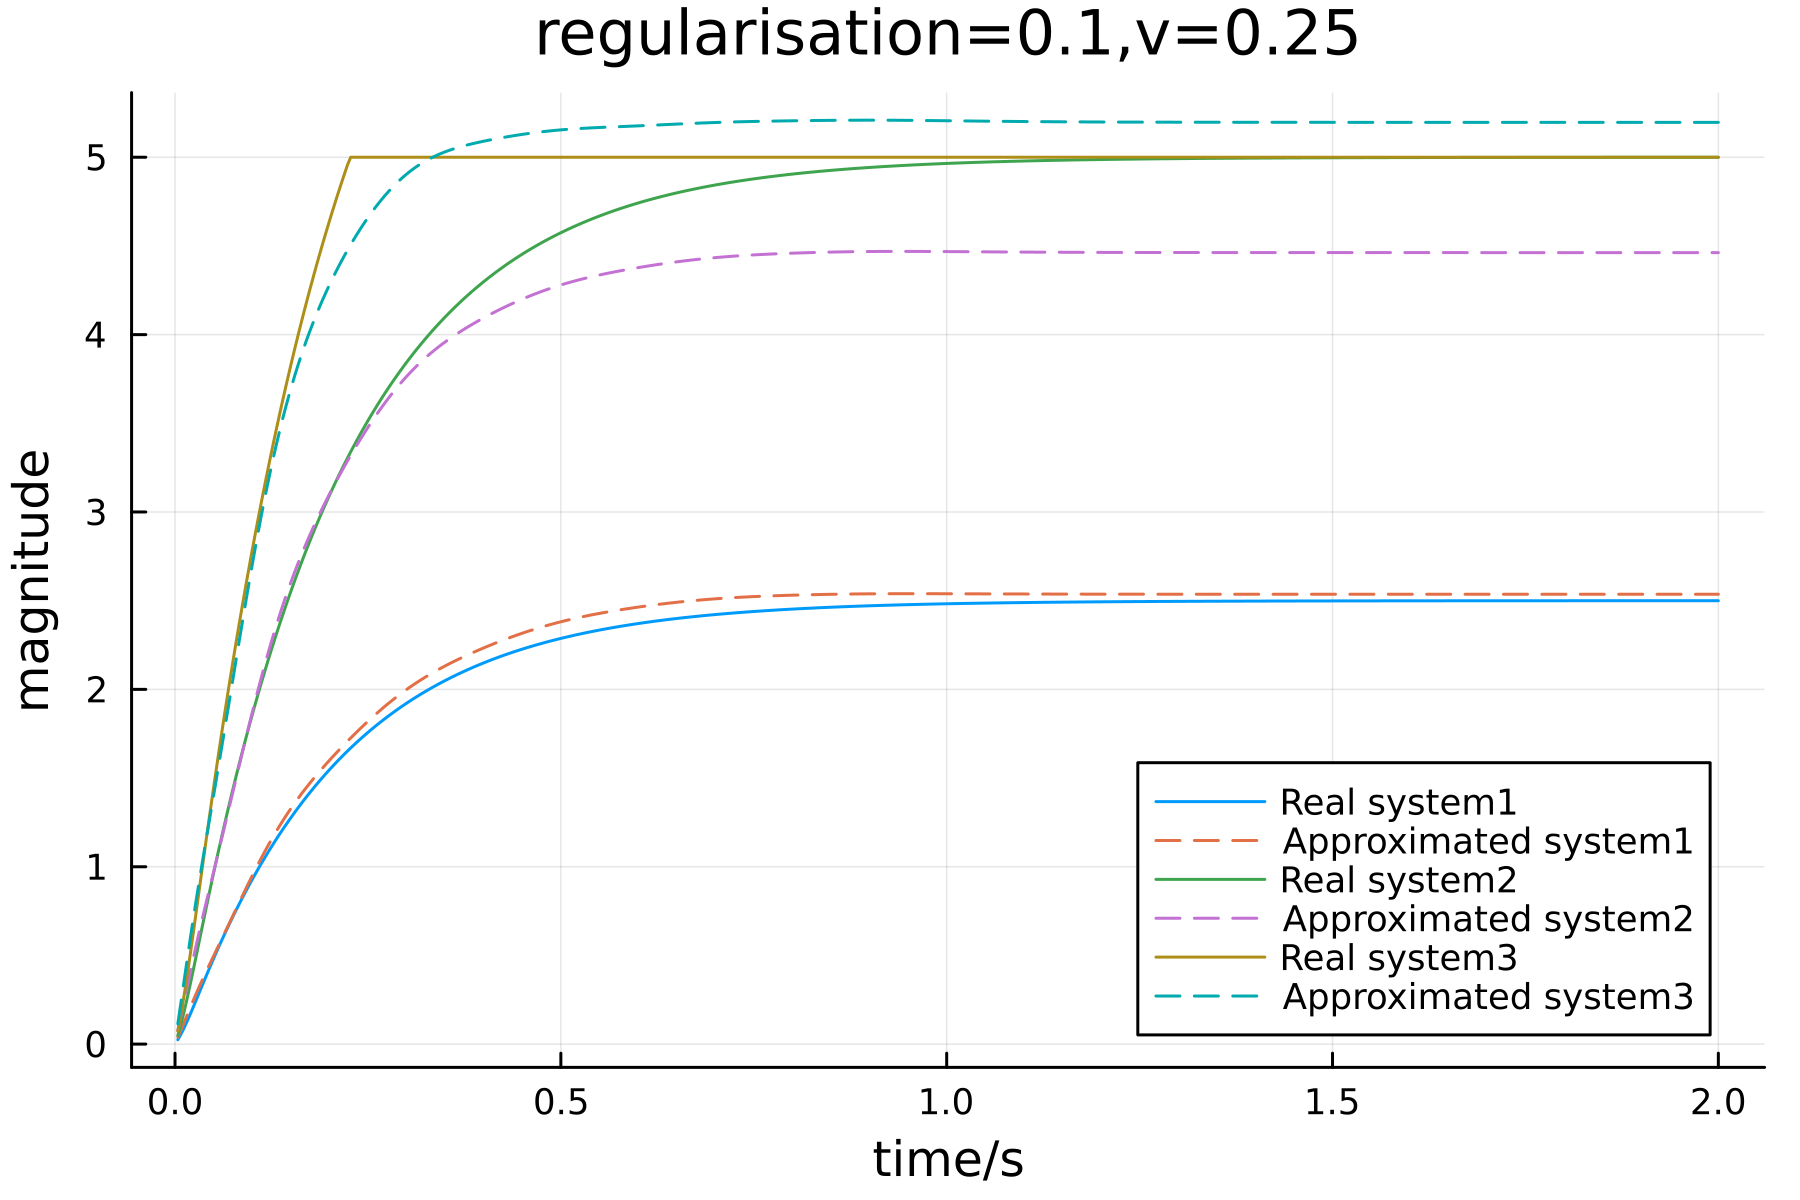

In [891]:
X_demos=[x_test2[20],x_test2[30],x_test2[40]]
Y_demos=[y_test2[20],y_test2[30],y_test2[40]]
plot_demo(MyKernel(),weights_o,tsample,X_train,X_demos,Y_demos,fading_weight,true,"Nonlinear_full")
plot_demo(MyKernel(),weights_o2,tsample,X_train,X_demos,Y_demos,fading_weight,true,"Nonlinear_full2")

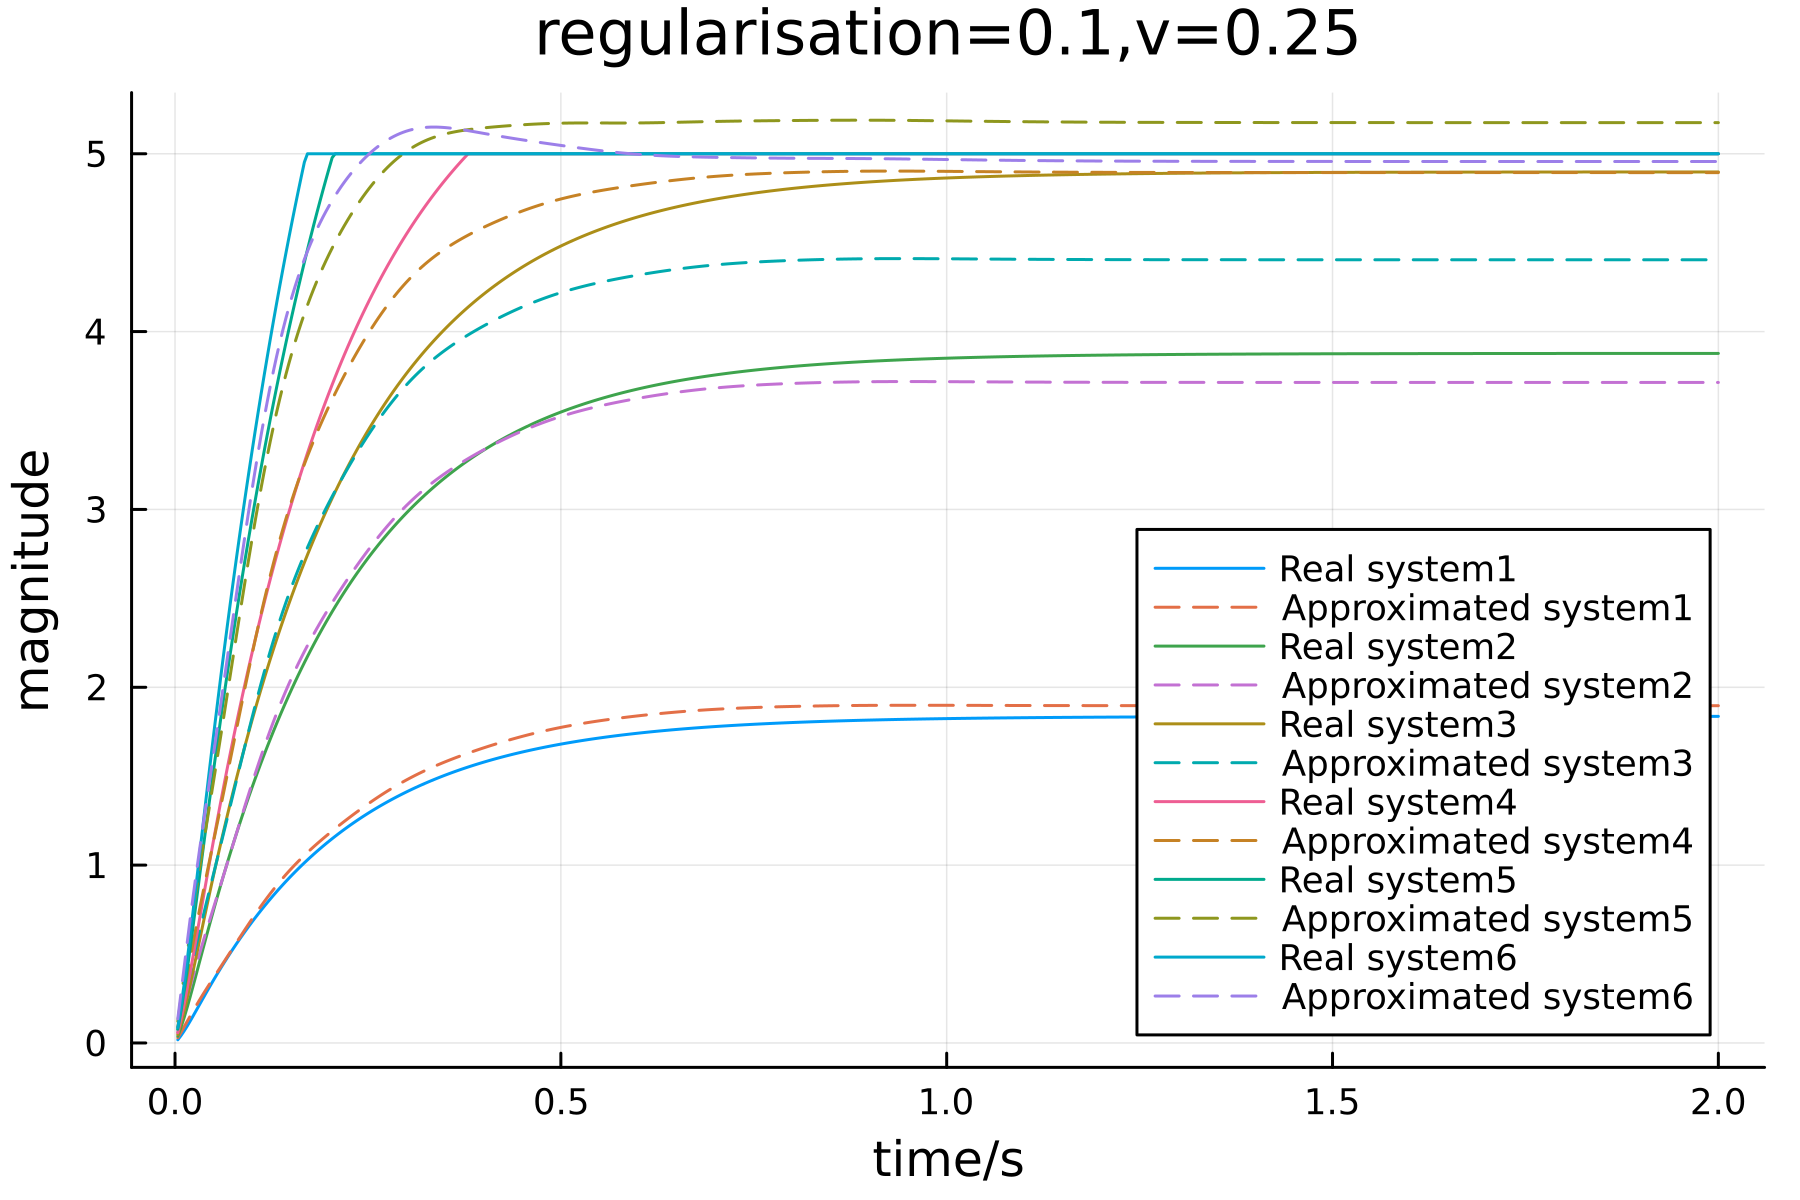

In [916]:
X_demos=[x_test2[10],x_test2[20],x_test2[25],x_test2[30],x_test2[40],x_test2[45]]
Y_demos=[y_test2[10],y_test2[20],y_test2[25],y_test2[30],y_test2[40],y_test2[45]]
plot_demo(MyKernel(),weights_o,tsample,X_train,X_demos,Y_demos,fading_weight,true,"Nonlinear_full3")
plot_demo(MyKernel(),weights_o2,tsample,X_train,X_demos,Y_demos,fading_weight,true,"Nonlinear_full4")

In [ ]:
X_demo=x_val[20]
Y_demo=y_val[20]
plot_demo(MyKernel(),weights_o,X_train,x_val[20],y_val[20],fading_weight)

In [ ]:
X_demo=x_test[5]
Y_demo=y_test[5]
plot_demo(MyKernel(),weights_o,X_train,X_demo,Y_demo,fading_weight)

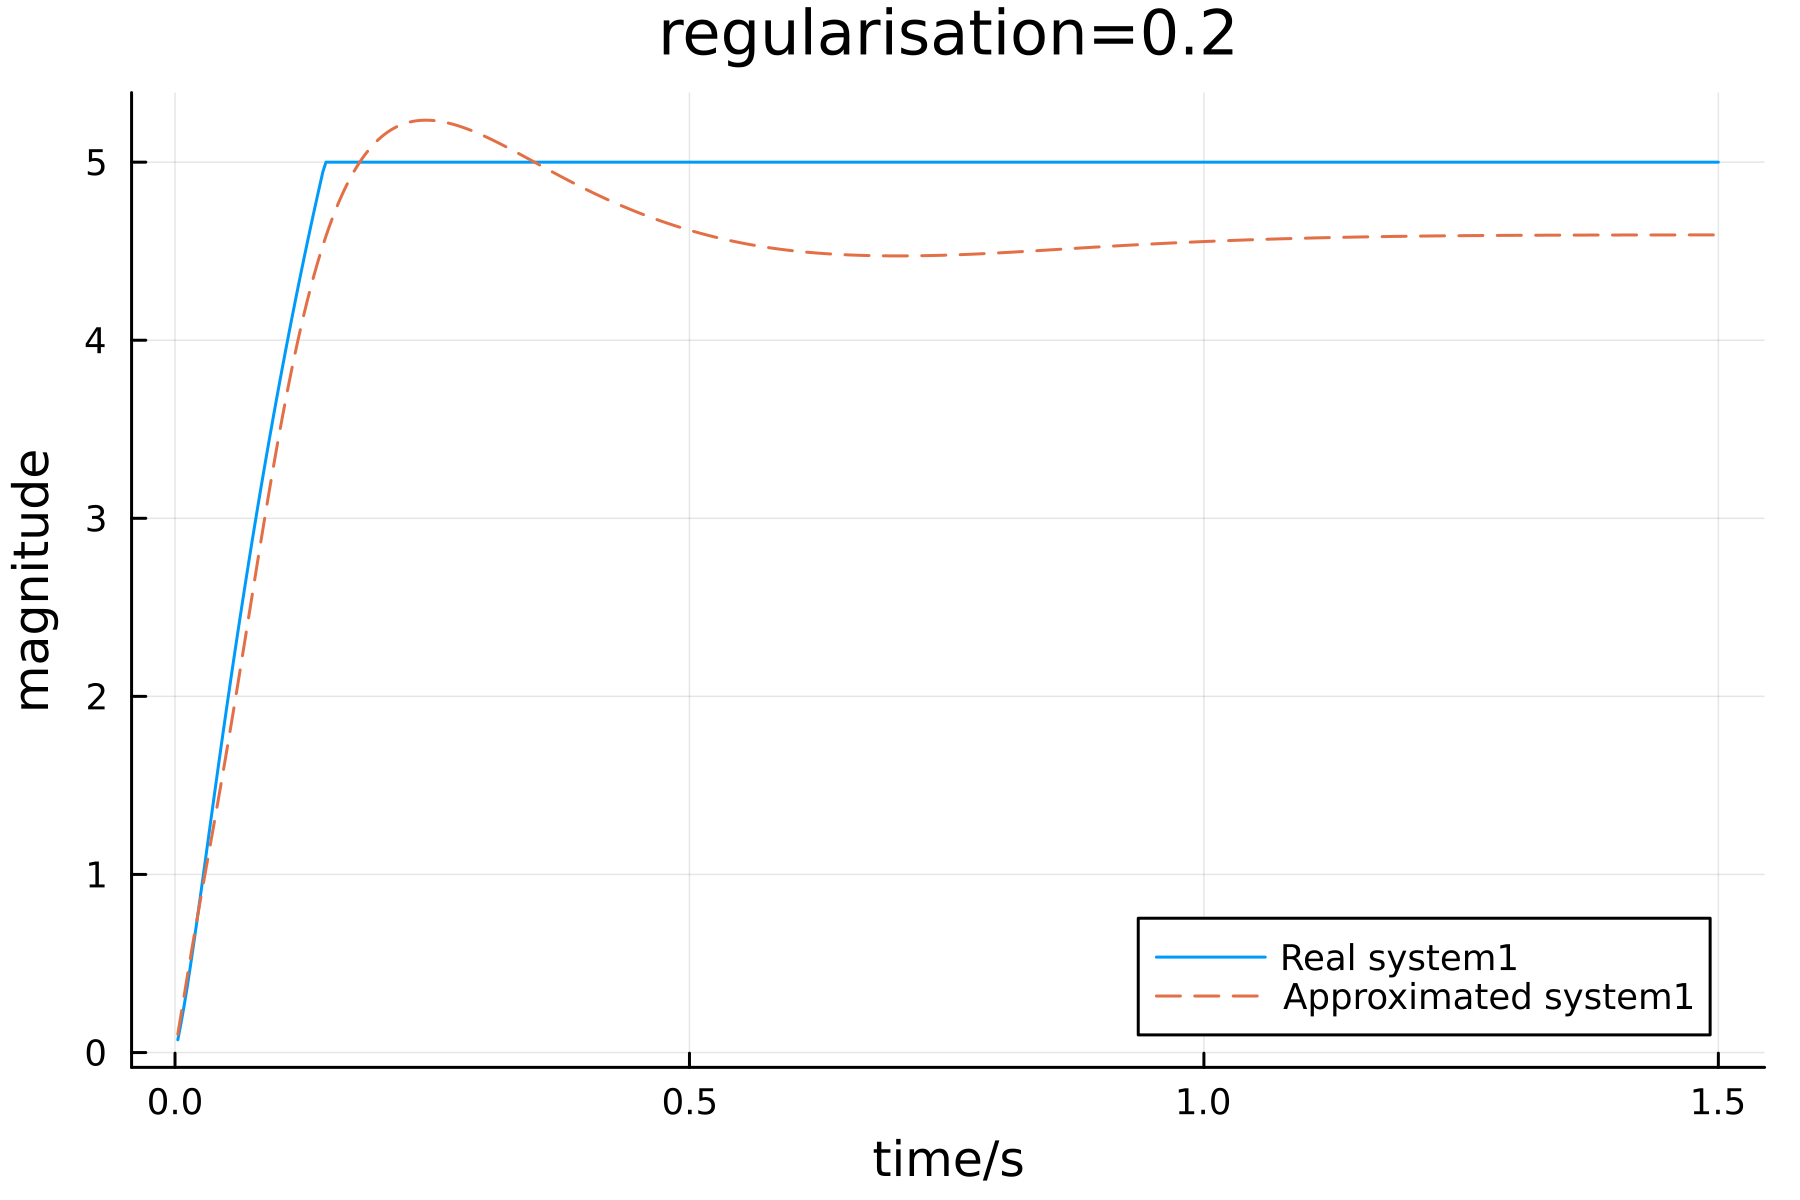

In [433]:
X_demo=[x_test2[5]]
Y_demo=[y_test2[5]]
plot_demo(MyKernel(),weights_o,tsample,X_train,X_demo,Y_demo,fading_weight)